# Продолжение 3

# ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА
слушателя курса "Data Science"

Образовательного центра

Московского государственного технического университета им. Н.Э. Баумана

Старостиной Ярославы Константиновны

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import tensorflow as tf

from numpy.random import seed
from pandas import read_excel, DataFrame, Series
from scipy import stats

from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge, LassoLars, LinearRegression, LogisticRegression, SGDRegressor, PoissonRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing

from tensorflow import keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel(r"C:\Users\Ярослава\DS_FQW_Komposit\Датасет для ВКР_композиты\itog.xlsx")
df.shape

(1023, 15)

Прогнозируем величину "Модуль упругости при растяжении, ГПа"

В качестве метрики возьмём среднюю абсолютную ошибку (mae) и коэффициент детерминации (r2) в прогнозах. Для обучения используем 70 % данных, а для тестирования — 30 %.

In [3]:
# проведем предобработку данных, как уже выявлено из Приложения 2, 
# для прогнозирования данной величины будем использовать совокупность
# Normalizer и StandartScaler
# norm = Normalizer().fit_transform(df)
# df_norm = pd.DataFrame(norm, columns = df.columns)
std = StandardScaler().fit_transform(df)
df_std = pd.DataFrame(std, columns = df.columns)
df_std.head()

,Unnamed: 0.1,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,-1.730359,-1.730359,-1.197501,0.779867,0.003103,0.000251,0.011062,-0.001329,-0.973486,-1.088651,1.148439,0.033133,-0.983518,-1.138798,-0.037245
1,-1.726972,-1.726972,-1.197501,0.779867,0.003103,-2.272468,0.636871,-0.033905,-0.973486,-1.088651,1.148439,0.033133,-0.983518,-1.138798,0.232119
2,-1.723586,-1.723586,-1.197501,0.779867,0.003103,-2.276220,-0.004609,-0.033905,-0.973486,-1.088651,1.148439,0.033133,-0.983518,-1.138798,1.129998
3,-1.720200,-1.720200,-1.197501,0.779867,0.003103,0.692038,-0.418711,0.357200,-0.973486,-1.088651,1.148439,0.033133,-0.983518,-0.742089,-0.935125
4,-1.716814,-1.716814,-0.172465,0.779867,0.046816,0.048853,0.011062,-0.033905,-0.973486,-1.088651,1.148439,0.033133,-0.983518,-0.742089,-0.037245


In [4]:
# разделим на тестовую и тренировочную выборки, 
# выделяя предикторы и целевые переменные
x_train, x_test, y_train, y_test = train_test_split(
    df_std.loc[:, df_std.columns != 'Модуль упругости при растяжении, ГПа'],
    df[['Модуль упругости при растяжении, ГПа']],
       test_size = 0.3,
    random_state = 42)
# Проверка правильности разбивки
df_std.shape[0] - x_train.shape[0] - x_test.shape[0]

0

In [5]:
x_train

,Unnamed: 0.1,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
604,0.314918,0.314918,0.732893,-1.583133,-1.213788,-1.331759,1.568672,0.682353,-1.695655,-2.292447,-0.998560,1.016758,1.346451,1.465657
227,-0.961687,-0.961687,0.002972,0.442764,0.652462,1.655270,0.818782,0.233561,0.823792,-2.424354,-1.310889,-0.983518,-0.097354,-1.262453
970,1.554275,1.554275,-0.723499,-0.399752,0.829593,1.543298,0.433252,0.187309,-0.714601,-0.336273,-0.122457,1.016758,-0.933566,-0.821561
497,-0.047407,-0.047407,0.102255,1.476042,1.178063,-0.186476,1.241430,-0.442368,-0.675283,-0.254809,-0.888297,-0.983518,-2.435934,2.388398
919,1.381578,1.381578,-1.003303,-0.199432,0.541583,0.339875,0.457423,-1.494837,-1.418197,-1.072793,-2.464136,1.016758,-0.097623,0.856948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-1.371419,-1.371419,-0.662189,0.652431,0.845216,-0.039514,0.882148,-0.500568,0.858837,-0.016606,0.810803,-0.983518,0.195572,1.055684
270,-0.816079,-0.816079,-0.821931,-0.559488,0.855828,-0.562483,1.710466,0.413760,-0.515286,-0.016606,-0.128848,-0.983518,2.145389,-0.332204
860,1.181791,1.181791,-0.308790,-1.725169,0.222271,0.329702,-0.444310,-0.148287,2.520768,0.028939,1.998443,1.016758,0.391241,0.250061
435,-0.257353,-0.257353,1.430476,0.434220,1.004785,1.034915,-1.666240,2.352371,0.494218,-1.639159,0.129148,-0.983518,-0.231805,-0.602080


In [6]:
y_train

,"Модуль упругости при растяжении, ГПа"
604,73.006935
227,69.215144
970,72.762976
497,70.199234
919,72.951915
...,...
106,68.166534
270,71.761063
860,72.558812
435,70.643900


In [7]:
x_test

,Unnamed: 0.1,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
525,0.047407,0.047407,0.969777,-0.169668,-0.197553,-1.380078,-1.452866,1.655955,-0.245745,0.228844,0.922291,-0.983518,-0.609900,-1.188268
357,-0.521478,-0.521478,-0.295875,-0.365780,-0.056629,-0.475948,-0.365400,-0.306594,1.782087,-0.110001,-0.955558,-0.983518,0.193361,-0.723156
444,-0.226877,-0.226877,0.279481,0.085370,-0.854067,-1.103081,-0.191821,0.925928,-0.887600,-0.529912,-0.306581,-0.983518,-1.250716,-0.759555
31,-1.625386,-1.625386,-1.293600,-1.444565,0.194026,-1.154416,0.023073,1.392806,1.380137,0.711656,-1.643145,1.016758,0.051329,1.129998
618,0.362326,0.362326,0.393975,-0.897261,-1.606702,-1.189942,-0.195378,-1.498839,-1.319953,0.576772,0.098531,1.016758,0.755968,0.093012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,-0.921052,-0.921052,0.701059,-1.190528,0.294327,0.387464,0.832910,-0.786233,0.226476,-0.463698,-0.172082,-0.983518,0.042215,1.046612
310,-0.680630,-0.680630,1.737742,0.107316,1.272344,-0.296626,-0.917118,-0.716054,1.199776,0.607670,0.045800,-0.983518,0.250406,1.270968
211,-1.015866,-1.015866,-0.256725,-0.211828,-2.178699,0.805813,-1.001900,1.621330,0.166543,-0.595249,0.018895,-0.983518,2.148994,1.403383
760,0.843169,0.843169,-0.489184,-0.772413,-0.636962,0.581487,1.335212,0.895760,-0.520895,-0.301386,-0.044714,1.016758,2.578778,-0.739610


In [8]:
y_test

,"Модуль упругости при растяжении, ГПа"
525,77.180805
357,77.171209
444,73.789821
31,70.947592
618,72.695218
...,...
239,73.769248
310,78.629422
211,74.659159
760,75.902153


In [9]:
# Метод линейной регрессии - Linear Regression

In [10]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred_lin_reg = lin_reg.predict(x_test)
mae_lin_reg = mean_absolute_error(y_pred_lin_reg, y_test)
r2_score_lin_reg = r2_score(y_test, y_pred_lin_reg)
print('mean absolute error:', round(mae_lin_reg, 2))
print("r2 score: ", round(r2_score_lin_reg, 2))

mean absolute error: 2.52
r2 score:  -0.03


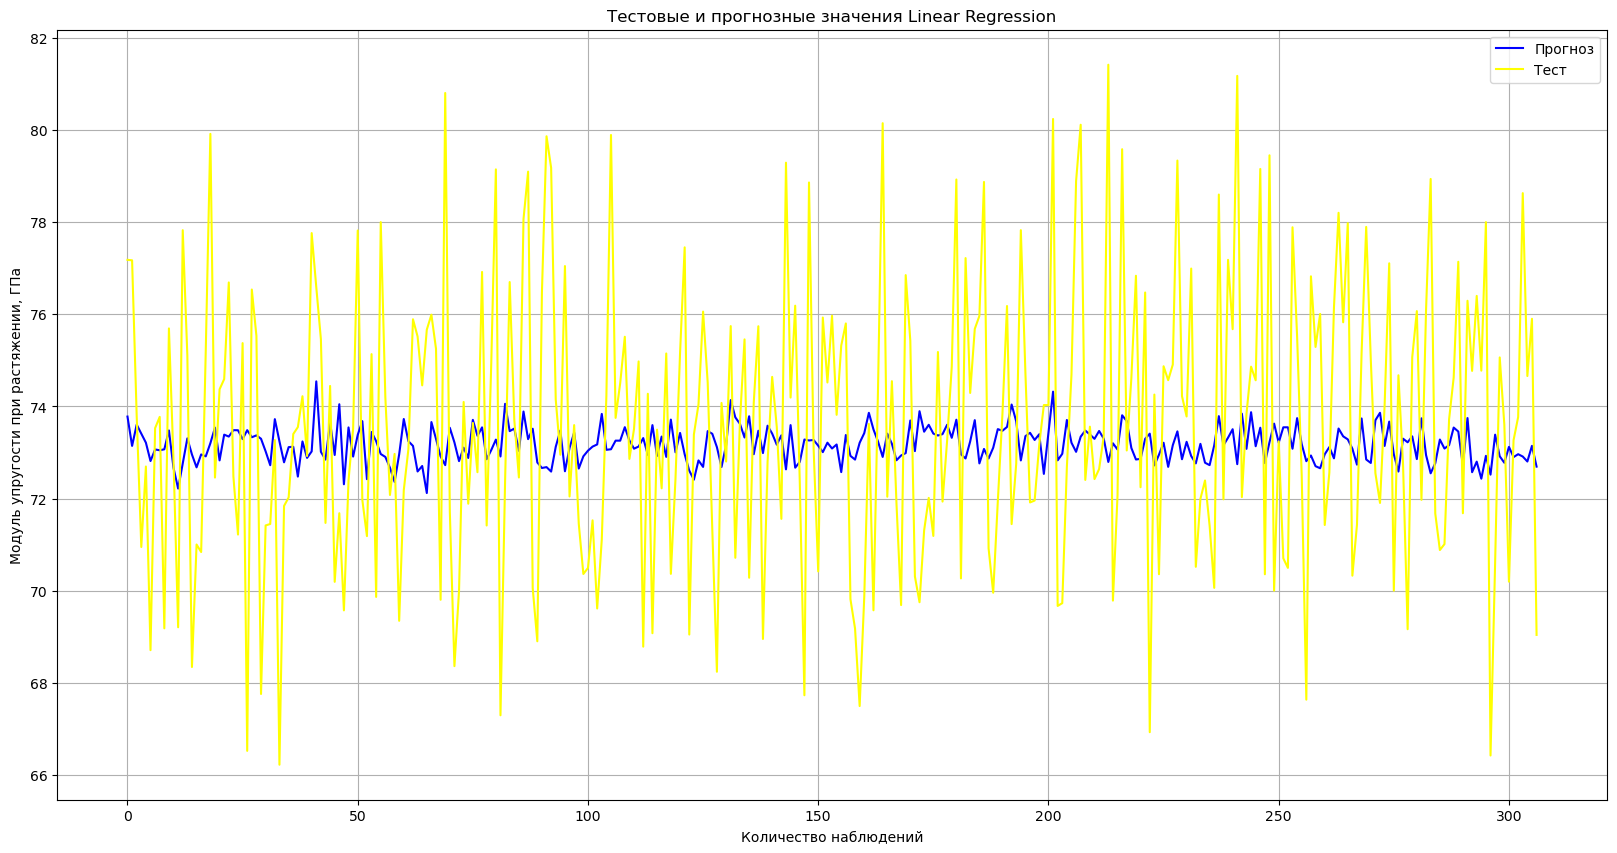

In [11]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Linear Regression")
plt.plot(y_pred_lin_reg, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [12]:
# Метод опорных векторов

In [13]:
svr_rbf = SVR(kernel="rbf", C=300, gamma=0.3, epsilon=0.5)
svr_rbf.fit(x_train, y_train)
y_pred_svr_rbf = svr_rbf.predict(x_test)
mae_svr_rbf = mean_absolute_error(y_pred_svr_rbf, y_test)
r2_score_svr_rbf = r2_score(y_test, y_pred_svr_rbf)
print('mean absolute error:', round(mae_svr_rbf, 2))
print("r2 score: ", round(r2_score_svr_rbf, 2))
# нашла лучшие С начинала от 100, gamma и epsilon начинала с 0.1

mean absolute error: 2.61
r2 score:  -0.13


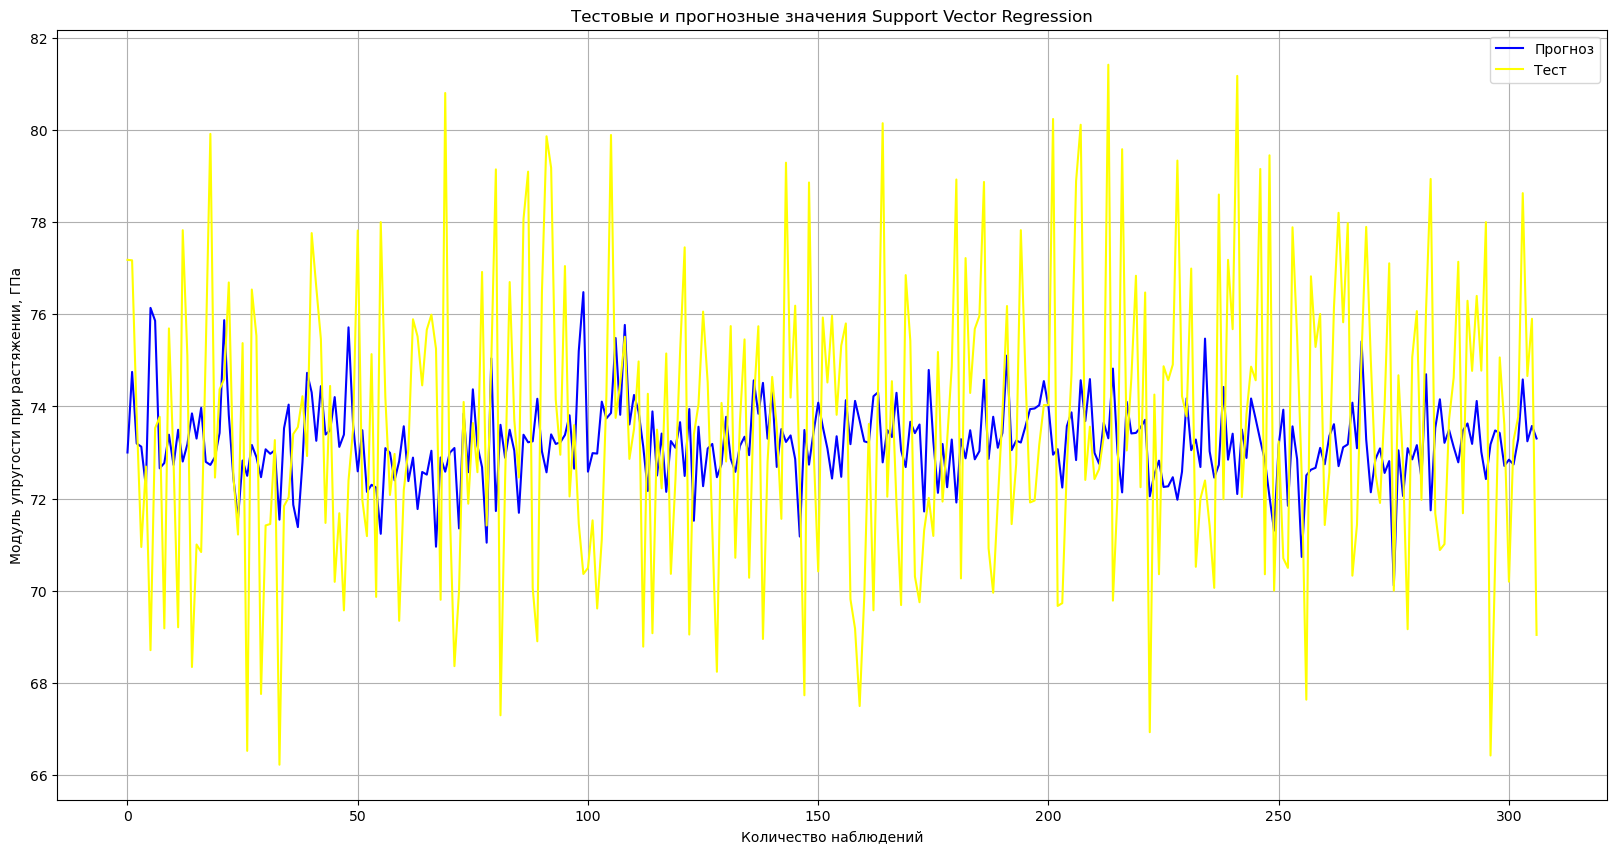

In [14]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Support Vector Regression")
plt.plot(y_pred_svr_rbf, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [15]:
svr_poly = SVR(kernel="poly", C=300, gamma='auto', degree=2, epsilon=0.3, coef0=0.3)
svr_poly.fit(x_train, y_train)
y_pred_svr_poly = svr_poly.predict(x_test)
mae_svr_poly = mean_absolute_error(y_pred_svr_poly, y_test)
r2_score_svr_poly = r2_score(y_test, y_pred_svr_poly)
print('mean absolute error:', round(mae_svr_poly, 2))
print("r2 score: ", round(r2_score_svr_poly, 2))
# нашла лучший gamma (начинала с 0.1, использовала 'scale'), degree (начинала с 1), epsilon и coef0 (начинала с 0.1 и 0.0)  

mean absolute error: 2.93
r2 score:  -0.49


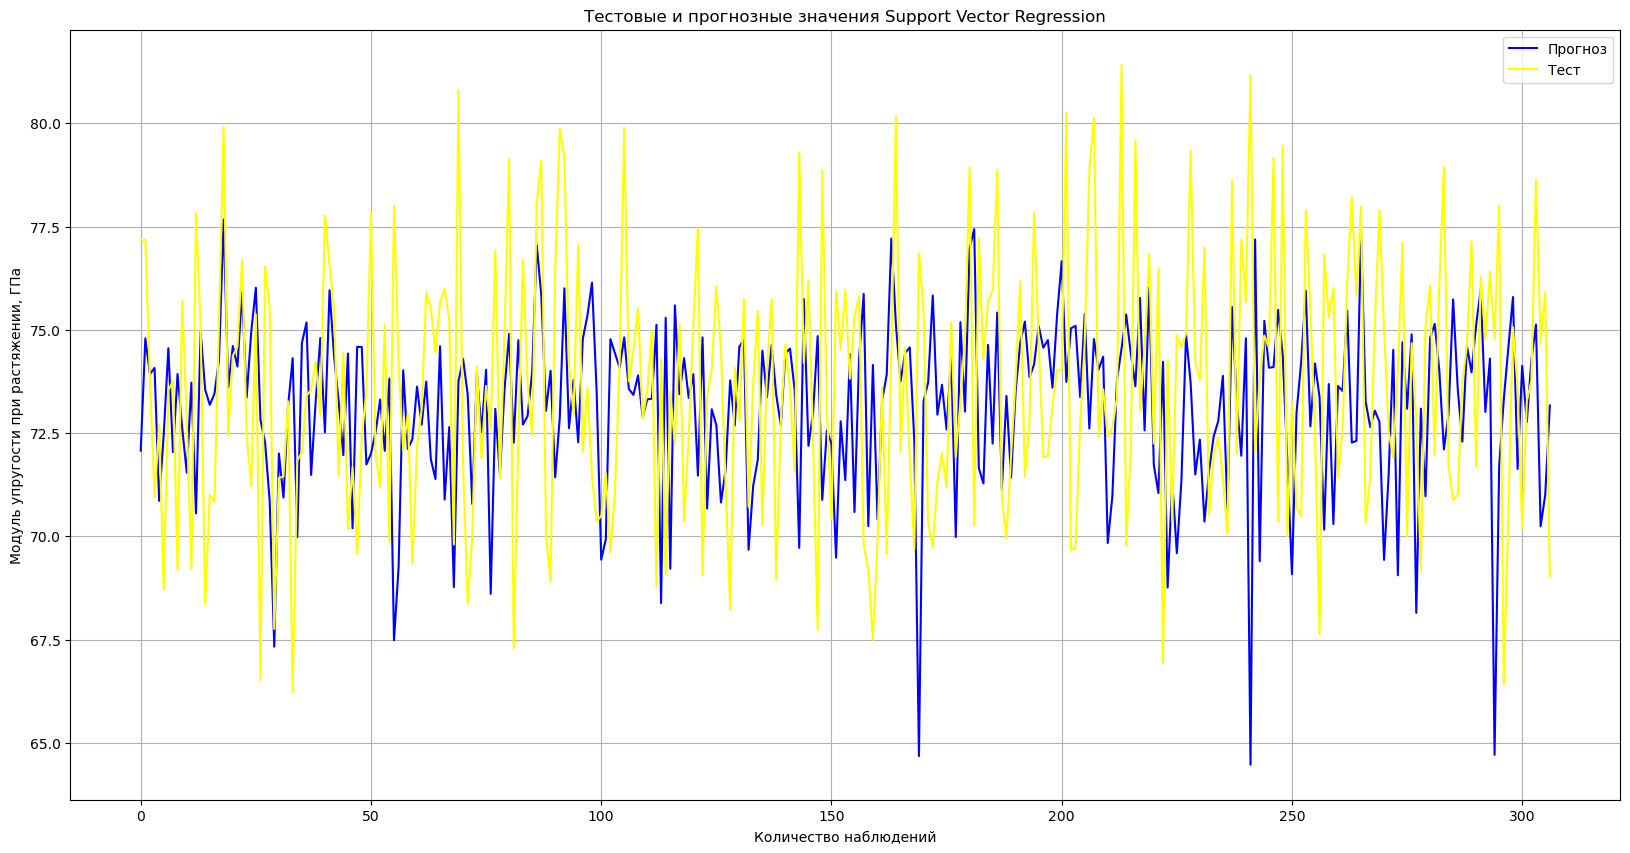

In [16]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Support Vector Regression")
plt.plot(y_pred_svr_poly, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [17]:
# Метод К ближайших соседей - K Neighbors Regressor

In [18]:
knr = KNeighborsRegressor(n_neighbors=5) # как по умолчанию
knr.fit(x_train, y_train.values)
y_pred_knr = knr.predict(x_test)
mae_knr = mean_absolute_error(y_pred_knr, y_test)
r2_score_knr = r2_score(y_test, y_pred_knr)
print('mean absolute error:', round(mae_knr, 2))
print("r2 score: ", round(r2_score_knr, 2))

mean absolute error: 2.83
r2 score:  -0.35


In [19]:
# Проведем поиск  по сетке гиперпараметров с перекрестной проверкой, количество блоков равно 10 (cv = 10), для 
# модели случайного леса - K Neighbors Regressor
parametrs_knr = { 'n_neighbors' : range(1, 501, 2),
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knr = GridSearchCV(estimator = knr, param_grid = parametrs_knr, cv = 10, verbose = 1, scoring = 'r2')
grid_knr.fit(x_train, y_train)
grid_knr.best_params_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits


{'algorithm': 'auto', 'n_neighbors': 49, 'weights': 'uniform'}

In [20]:
# подставим эти значения
knr = KNeighborsRegressor(n_neighbors=137, algorithm='auto', weights='uniform')
knr.fit(x_train, y_train.values)
y_pred_knr = knr.predict(x_test)
mae_knr = mean_absolute_error(y_pred_knr, y_test)
r2_score_knr = r2_score(y_test, y_pred_knr)
print('mean absolute error:', round(mae_knr, 2))
print("r2 score: ", round(r2_score_knr, 2))

mean absolute error: 2.49
r2 score:  -0.01


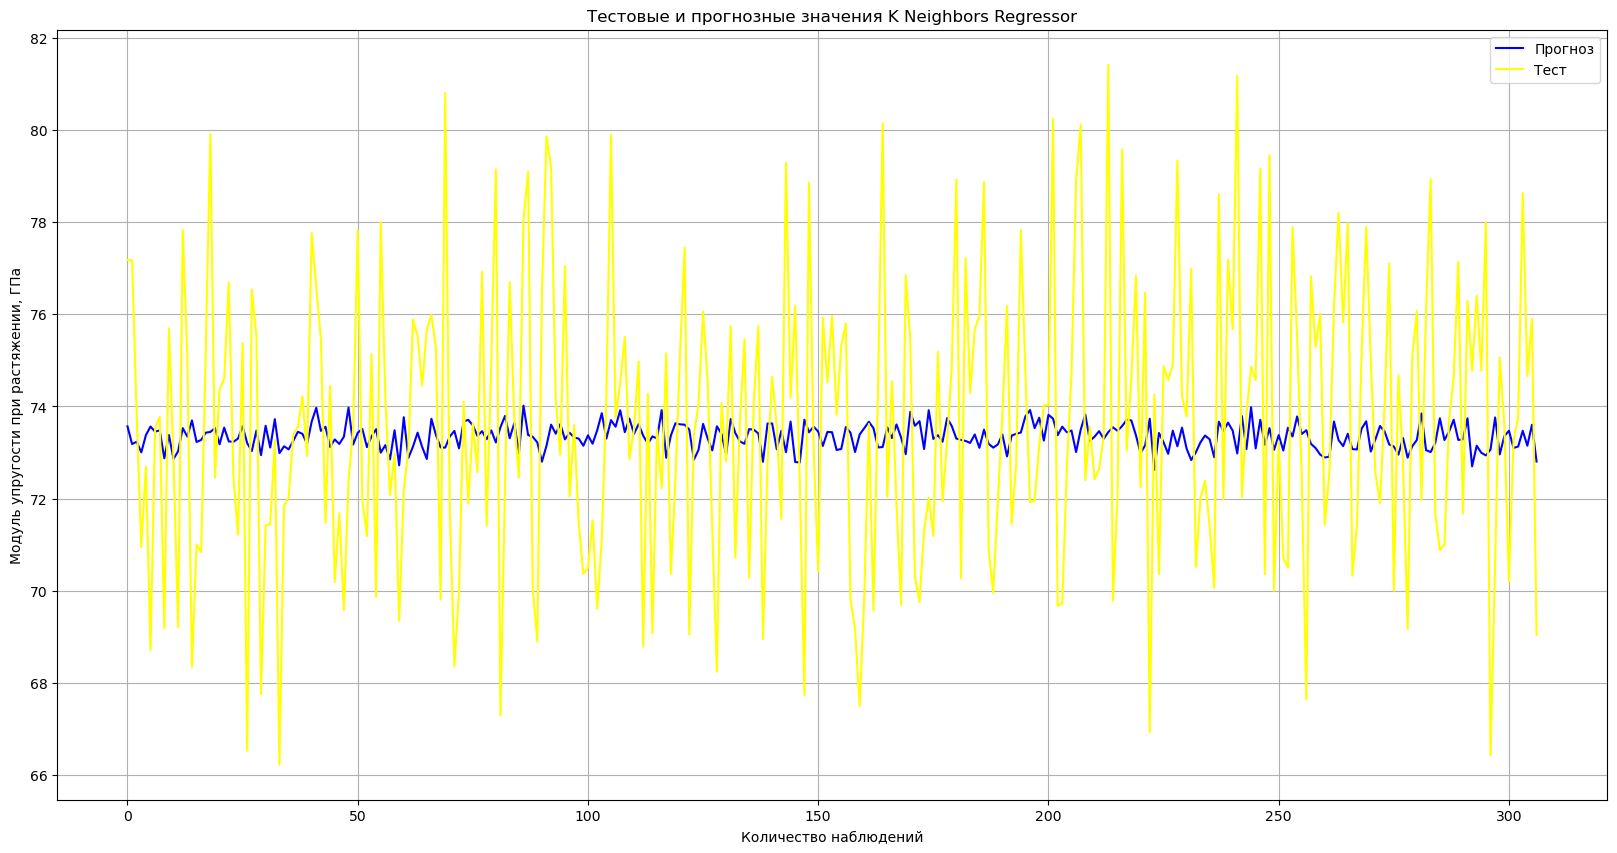

In [21]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения K Neighbors Regressor")
plt.plot(y_pred_knr, label = "Прогноз", color = 'blue')
plt.plot(y_test.values, label = "Тест", color = 'yellow')
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [22]:
#Деревья решений - Decision Tree Regressor

In [23]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train.values)
y_pred_dtr = dtr.predict(x_test)
mae_dtr = mean_absolute_error(y_pred_dtr, y_test)
r2_score_dtr = r2_score(y_test, y_pred_dtr)
print('mean absolute error:', round(mae_dtr, 2))
print("r2 score: ", round(r2_score_dtr, 2))

mean absolute error: 3.45
r2 score:  -0.96


In [24]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']
max_depth = [3, 5, 7, 9, 11, 13, 15]
min_samples_leaf = [100, 150, 200, 250, 300]
min_samples_split = [100, 200, 300, 400]
max_features = ['auto', 'sqrt', 'log2']
param_grid_dtr = {'criterion': criterion,
               'splitter': splitter,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}
grid_dtr = GridSearchCV(dtr, param_grid_dtr, cv = 10, verbose = 1, scoring = 'r2')
grid_dtr.fit(x_train, y_train)
grid_dtr.best_params_

Fitting 10 folds for each of 3360 candidates, totalling 33600 fits


{'criterion': 'absolute_error',
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 250,
 'min_samples_split': 300,
 'splitter': 'best'}

In [25]:
# подставим эти значения
dtr = DecisionTreeRegressor(max_depth=9, 
                            max_features='log2', 
                            min_samples_leaf=300,
                            min_samples_split=100,
                            splitter='best')
dtr.fit(x_train, y_train.values)
y_pred_dtr = dtr.predict(x_test)
mae_dtr = mean_absolute_error(y_pred_dtr, y_test)
r2_score_dtr = r2_score(y_test, y_pred_dtr)
print('mean absolute error:', round(mae_dtr, 2))
print("r2 score: ", round(r2_score_dtr, 2))

mean absolute error: 2.52
r2 score:  -0.03


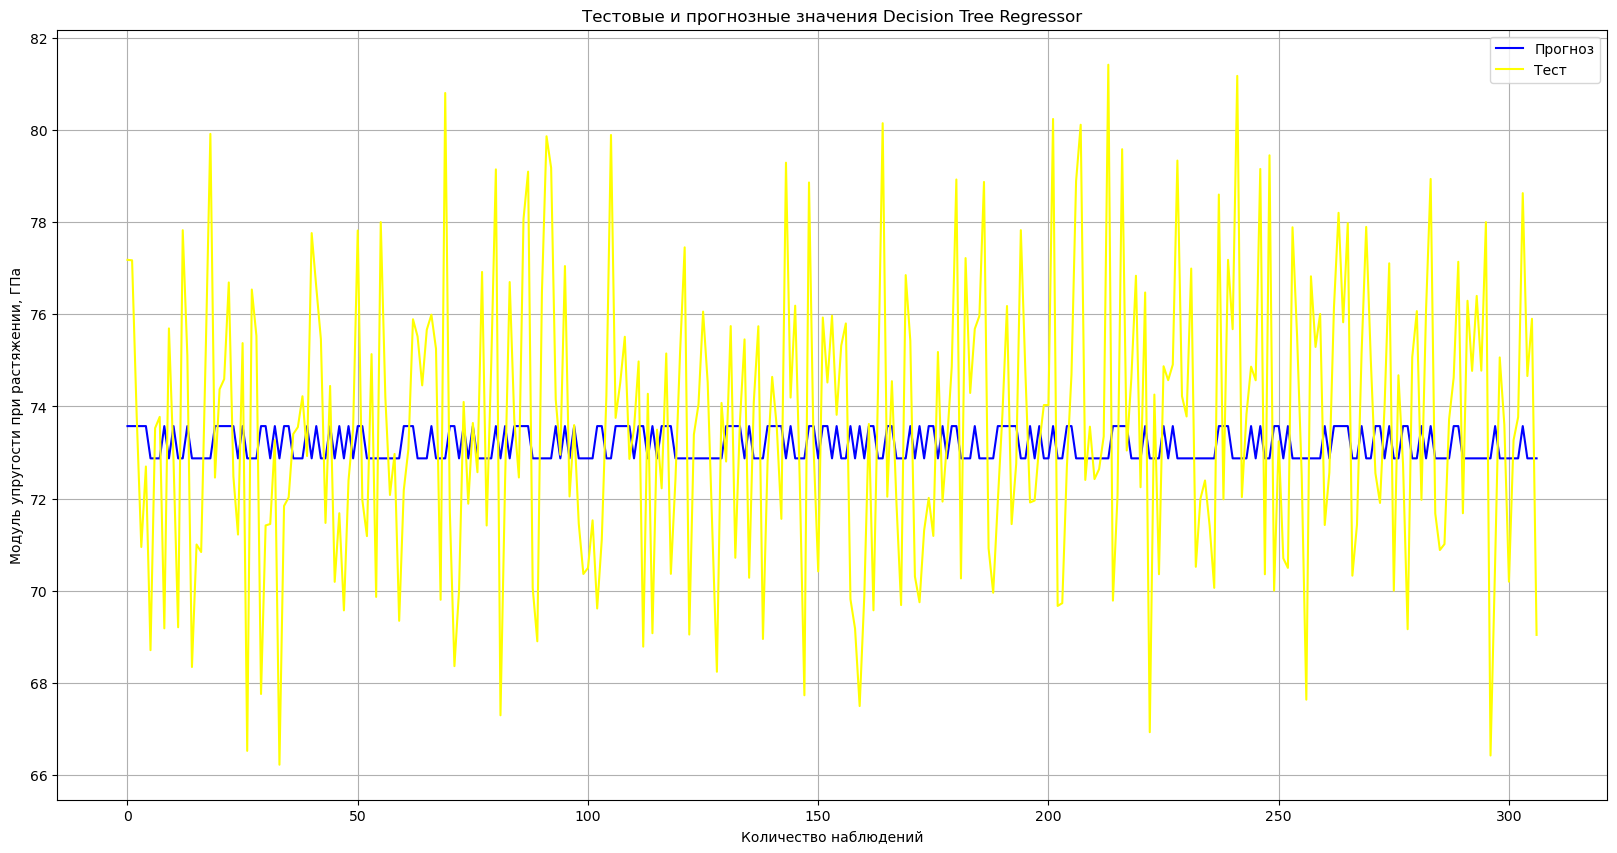

In [26]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Decision Tree Regressor")
plt.plot(y_pred_dtr, label = "Прогноз", color = 'blue')
plt.plot(y_test.values, label = "Тест", color = 'yellow')
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [27]:
# Метод случайного леса - Random Forest Regressor

In [28]:
rfr = RandomForestRegressor(random_state=26)
rfr.fit(x_train, y_train.values)
y_pred_rfr = rfr.predict(x_test)
mae_rfr = mean_absolute_error(y_pred_rfr, y_test)
r2_score_rfr = r2_score(y_test, y_pred_rfr)
print('mean absolute error:', round(mae_rfr, 2))
print("r2 score: ", round(r2_score_rfr, 2))

mean absolute error: 2.61
r2 score:  -0.11


In [29]:
# Проведем поиск  по сетке гиперпараметров с перекрестной проверкой, количество блоков равно 10 (cv = 10), для 
# модели случайного леса - Random Forest Regressor

parametrs_rfr = { 'n_estimators': [100, 500],
              'max_depth': [5, 15],
              'max_features': ['auto'],
              'criterion': ['mse'] }
grid_rfr = GridSearchCV(estimator = rfr, param_grid = parametrs_rfr, cv = 10)
grid_rfr.fit(x_train, y_train)
grid_rfr.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 100}

In [30]:
# подставим эти значения
rfr = RandomForestRegressor(n_estimators = 500, max_depth = 5, max_features='auto', random_state=26)
rfr.fit(x_train, y_train.values)
y_pred_rfr = rfr.predict(x_test)
mae_rfr = mean_absolute_error(y_pred_rfr, y_test)
r2_score_rfr = r2_score(y_test, y_pred_rfr)
print('mean absolute error:', round(mae_rfr, 2))
print("r2 score: ", round(r2_score_rfr, 2))

mean absolute error: 2.56
r2 score:  -0.06


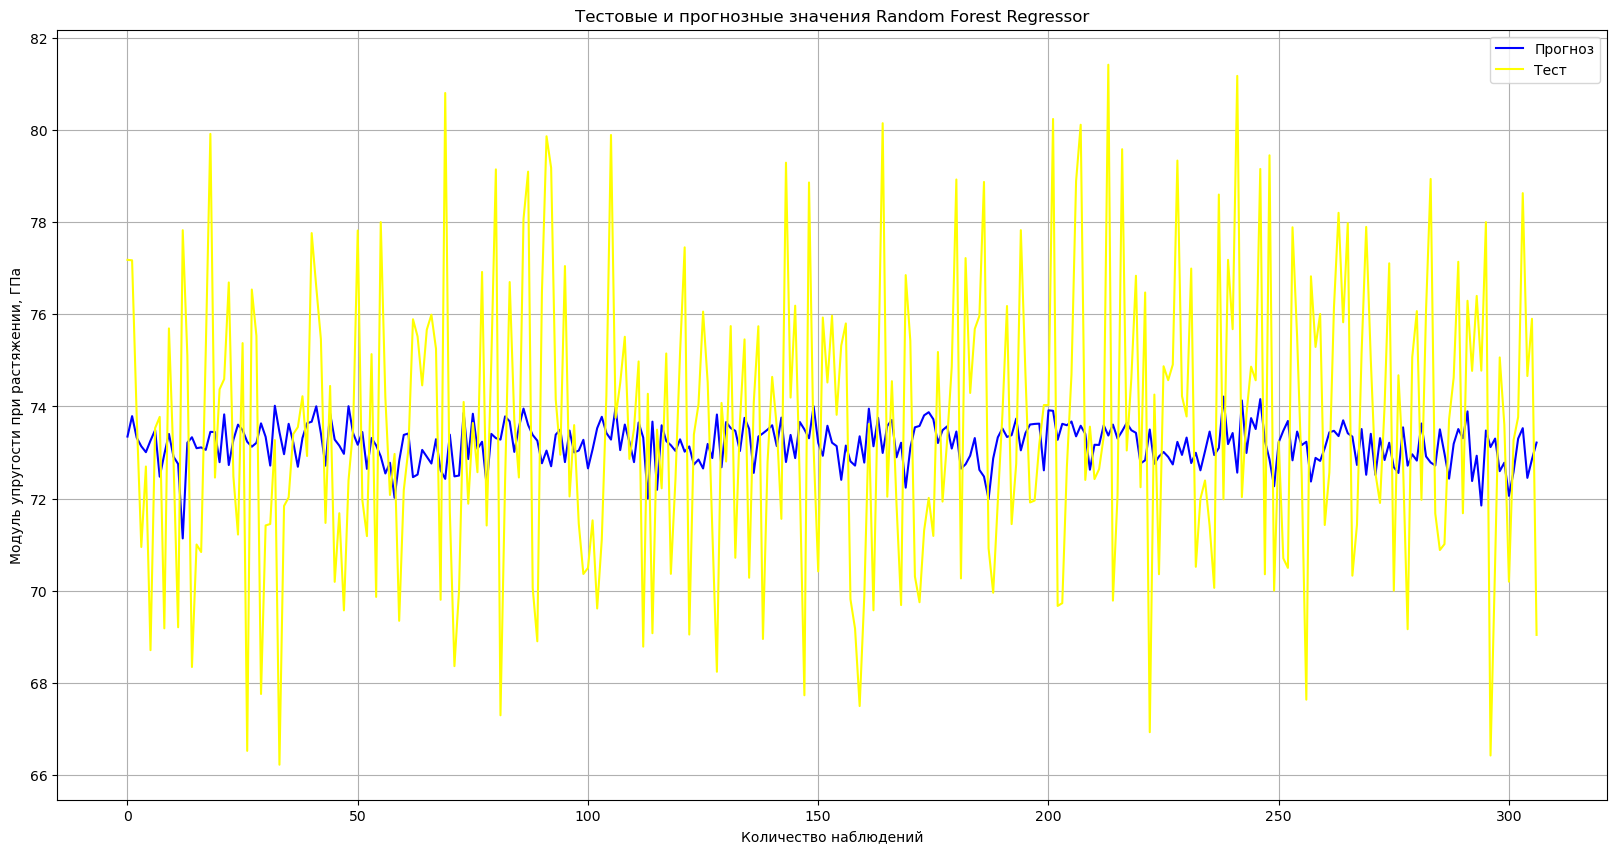

In [31]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Random Forest Regressor")
plt.plot(y_pred_rfr, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [32]:
# Модель Gradient Boosting Regressor

In [33]:
gbr = GradientBoostingRegressor(random_state=26)
gbr.fit(x_train, y_train.values)
y_pred_gbr = gbr.predict(x_test)
mae_gbr = mean_absolute_error(y_pred_gbr, y_test)
r2_score_gbr = r2_score(y_test, y_pred_gbr)
print('mean absolute error:', round(mae_gbr, 2))
print("r2 score: ", round(r2_score_gbr, 2))

mean absolute error: 2.58
r2 score:  -0.11


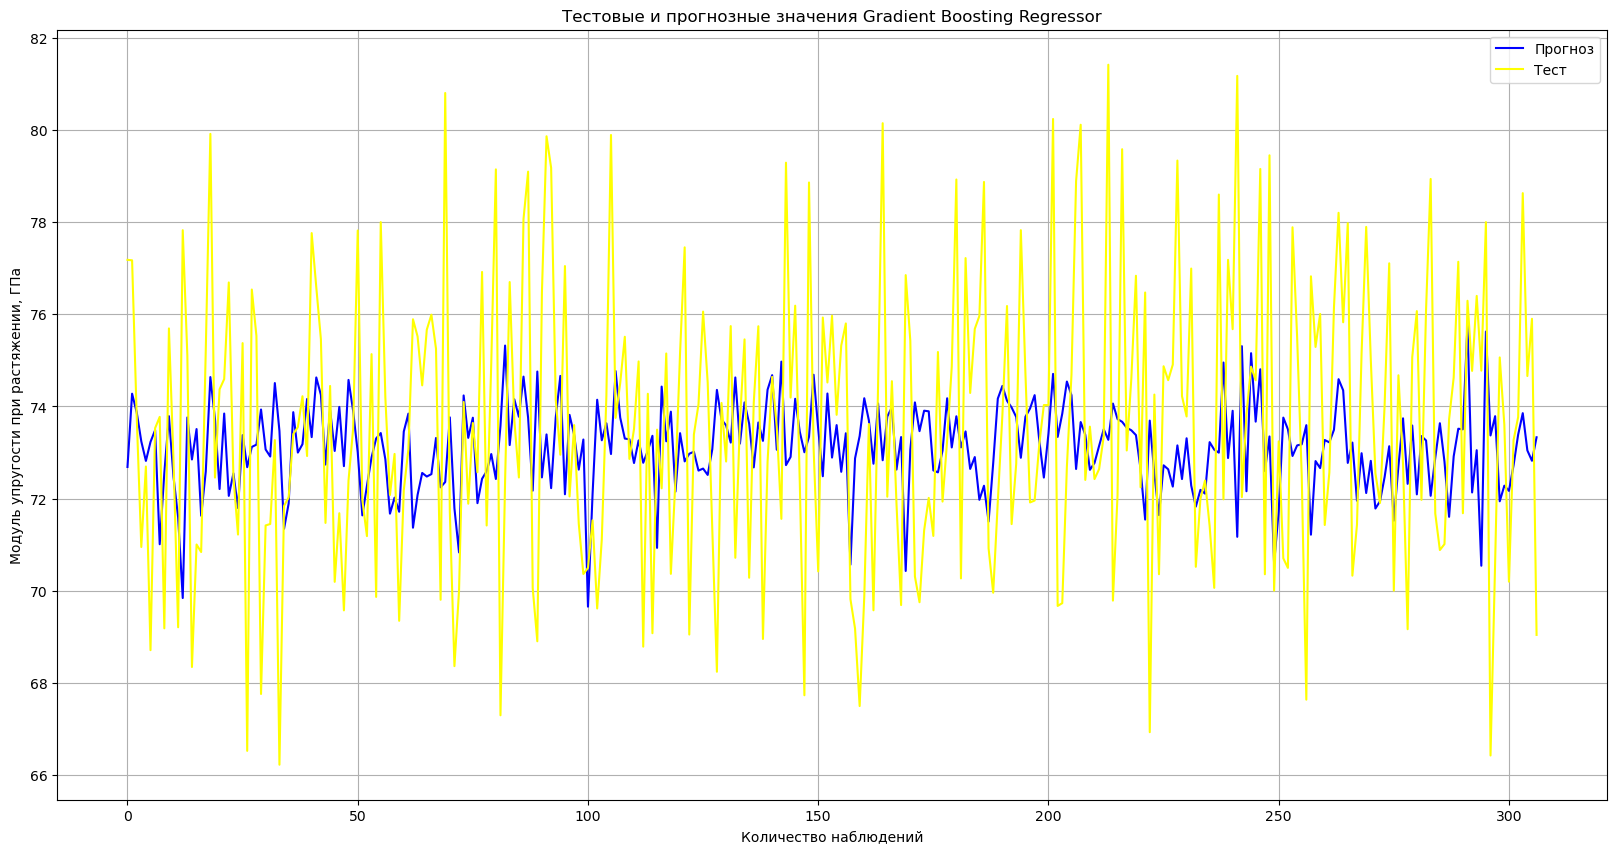

In [34]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Gradient Boosting Regressor")
plt.plot(y_pred_gbr, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [35]:
# Стохастический градиентный спуск (SGD) - Stochastic Gradient Descent Regressor

In [36]:
sgdr = SGDRegressor()
sgdr.fit(x_train, y_train.values)
y_pred_sgdr = sgdr.predict(x_test)
mae_sgdr = mean_absolute_error(y_pred_sgdr, y_test)
r2_score_sgdr = r2_score(y_test, y_pred_sgdr)
print('mean absolute error:', round(mae_sgdr, 2))
print("r2 score: ", round(r2_score_sgdr, 2))

mean absolute error: 2.52
r2 score:  -0.03


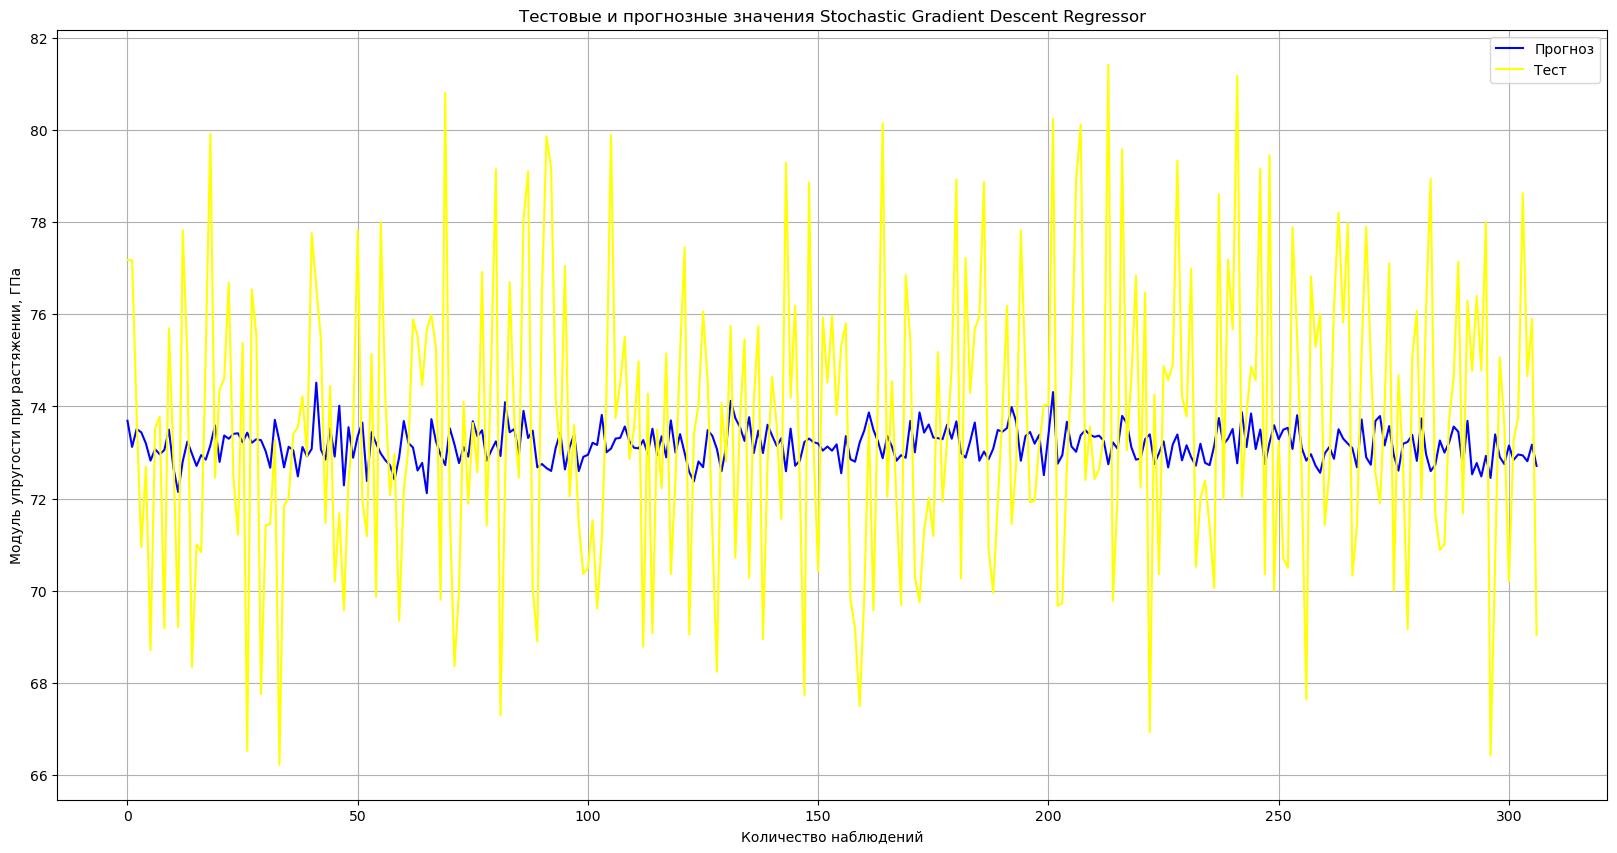

In [37]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Stochastic Gradient Descent Regressor")
plt.plot(y_pred_sgdr, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [38]:
# Модель Лассо соответствует регрессии с наименьшим углом, также известной как Ларс - LassoLars

In [39]:
ll = LassoLars(alpha=0)
ll.fit(x_train, y_train.values)
y_pred_ll = ll.predict(x_test)
mae_ll = mean_absolute_error(y_pred_ll, y_test)
r2_score_ll = r2_score(y_test, y_pred_ll)
print('mean absolute error:', round(mae_ll, 2))
print("r2 score: ", round(r2_score_ll, 2))

mean absolute error: 2.51
r2 score:  -0.02


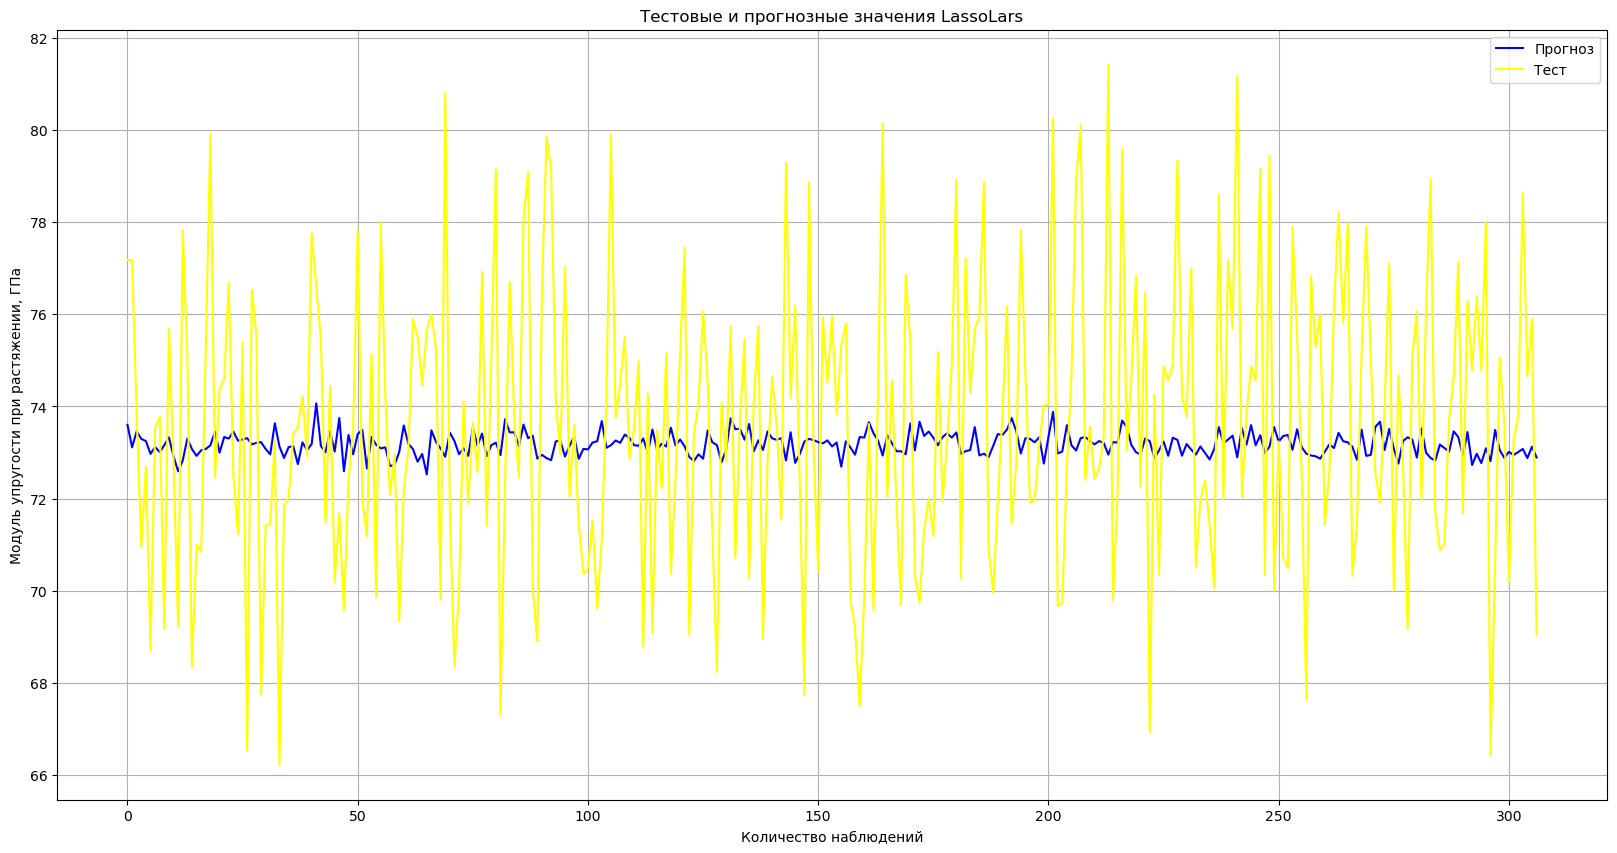

In [40]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения LassoLars")
plt.plot(y_pred_ll, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [41]:
# Модель регрессия байесовского гребня - Bayesian Ridge

In [42]:
br = BayesianRidge(n_iter = 1)
br.fit(x_train, y_train.values)
y_pred_br = br.predict(x_test)
mae_br = mean_absolute_error(y_pred_br, y_test)
r2_score_br = r2_score(y_test, y_pred_br)
print('mean absolute error:', round(mae_br, 2))
print("r2 score: ", round(r2_score_br, 2))

mean absolute error: 2.51
r2 score:  -0.02


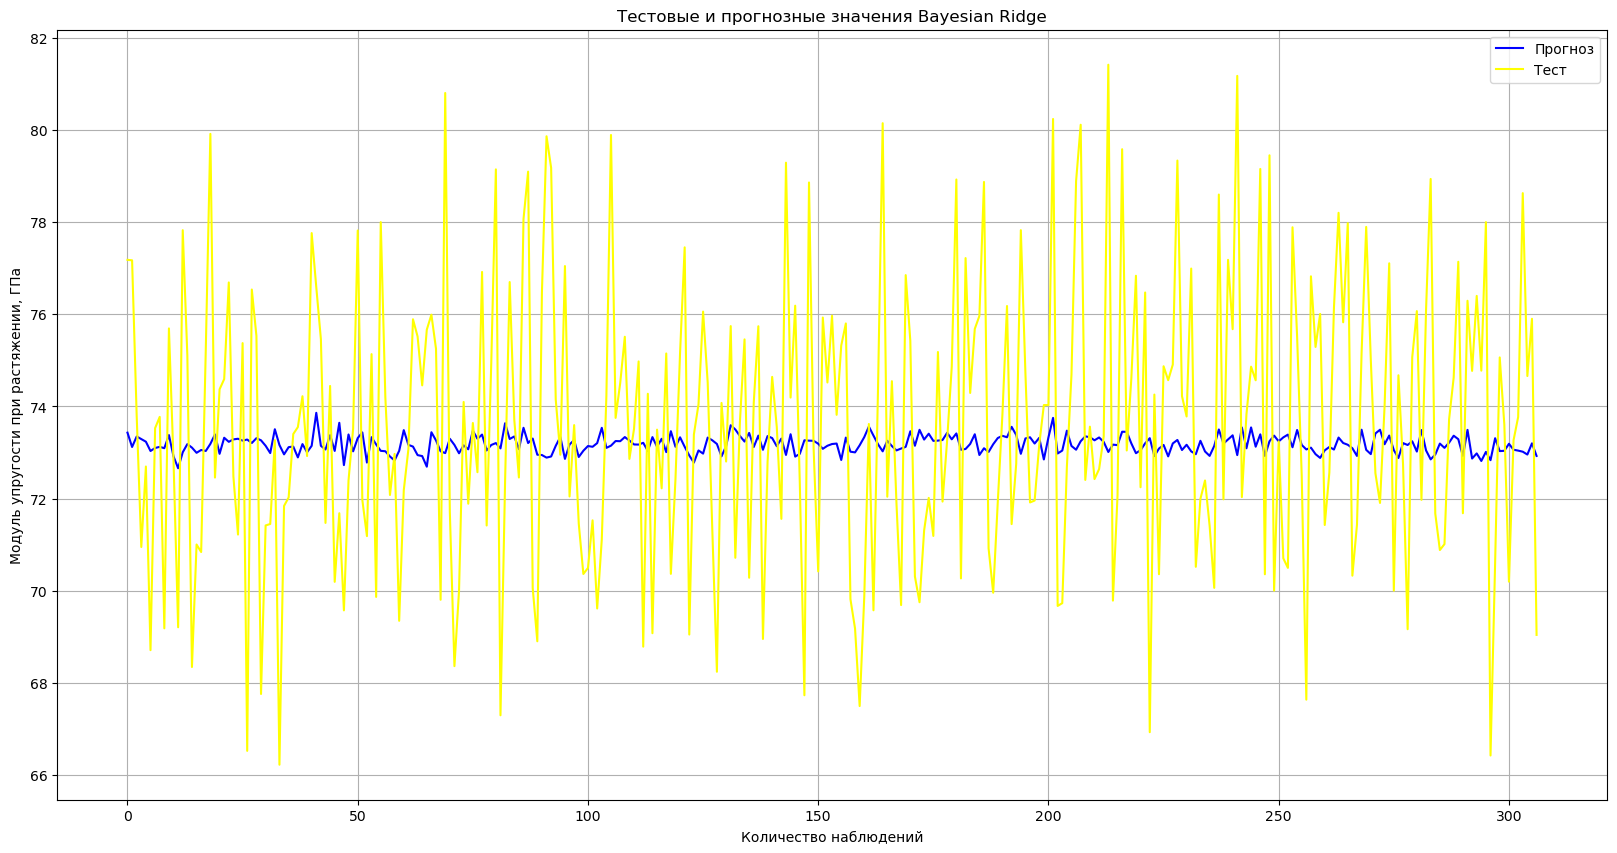

In [43]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Bayesian Ridge")
plt.plot(y_pred_br, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [44]:
# линейная модель с распределением Пуассона - Poisson Regressor

In [45]:
pr = PoissonRegressor(alpha = 1.0) # по умолчанию
pr.fit(x_train, y_train.values)
y_pred_pr = pr.predict(x_test)
mae_pr = mean_absolute_error(y_pred_pr, y_test)
r2_score_pr = r2_score(y_test, y_pred_pr)
print('mean absolute error:', round(mae_pr, 2))
print("r2 score: ", round(r2_score_pr, 2))

mean absolute error: 2.52
r2 score:  -0.03


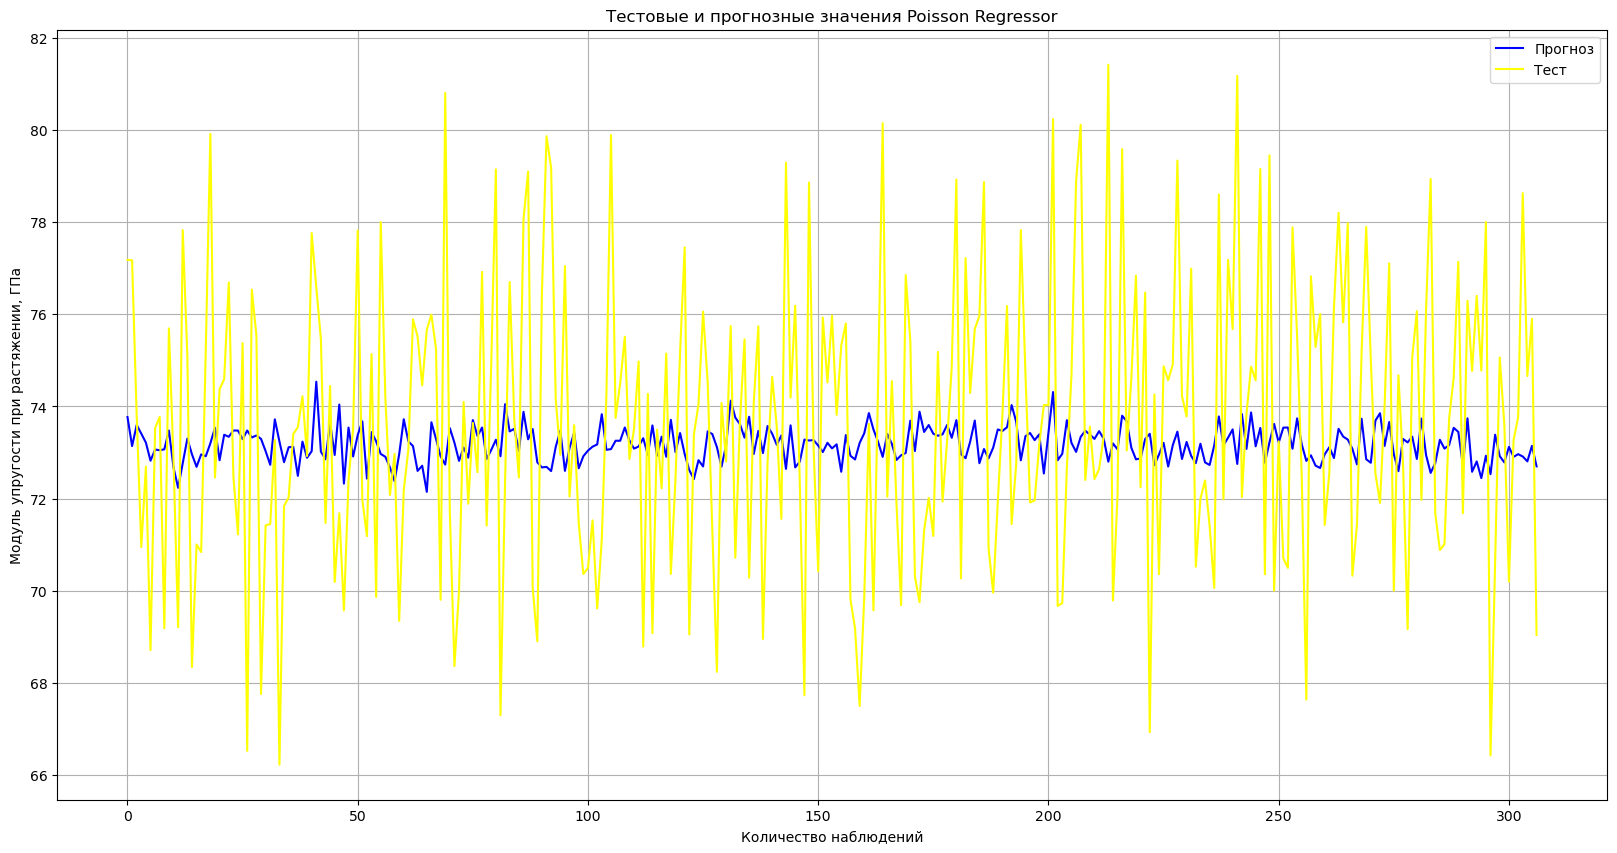

In [46]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Poisson Regressor")
plt.plot(y_pred_pr, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [47]:
# Многослойный перцептрон - Multi-layer Perceptron regressor

In [48]:
mlp = MLPRegressor(random_state = 26, max_iter = 2000)
mlp.fit(x_train, y_train.values)
y_pred_mlp = mlp.predict(x_test)
mae_mlp = mean_absolute_error(y_pred_mlp, y_test)
r2_score_mlp = r2_score(y_test, y_pred_mlp)
print('mean absolute error:', round(mae_mlp, 2))
print("r2 score: ", round(r2_score_mlp, 2))

mean absolute error: 3.22
r2 score:  -0.75


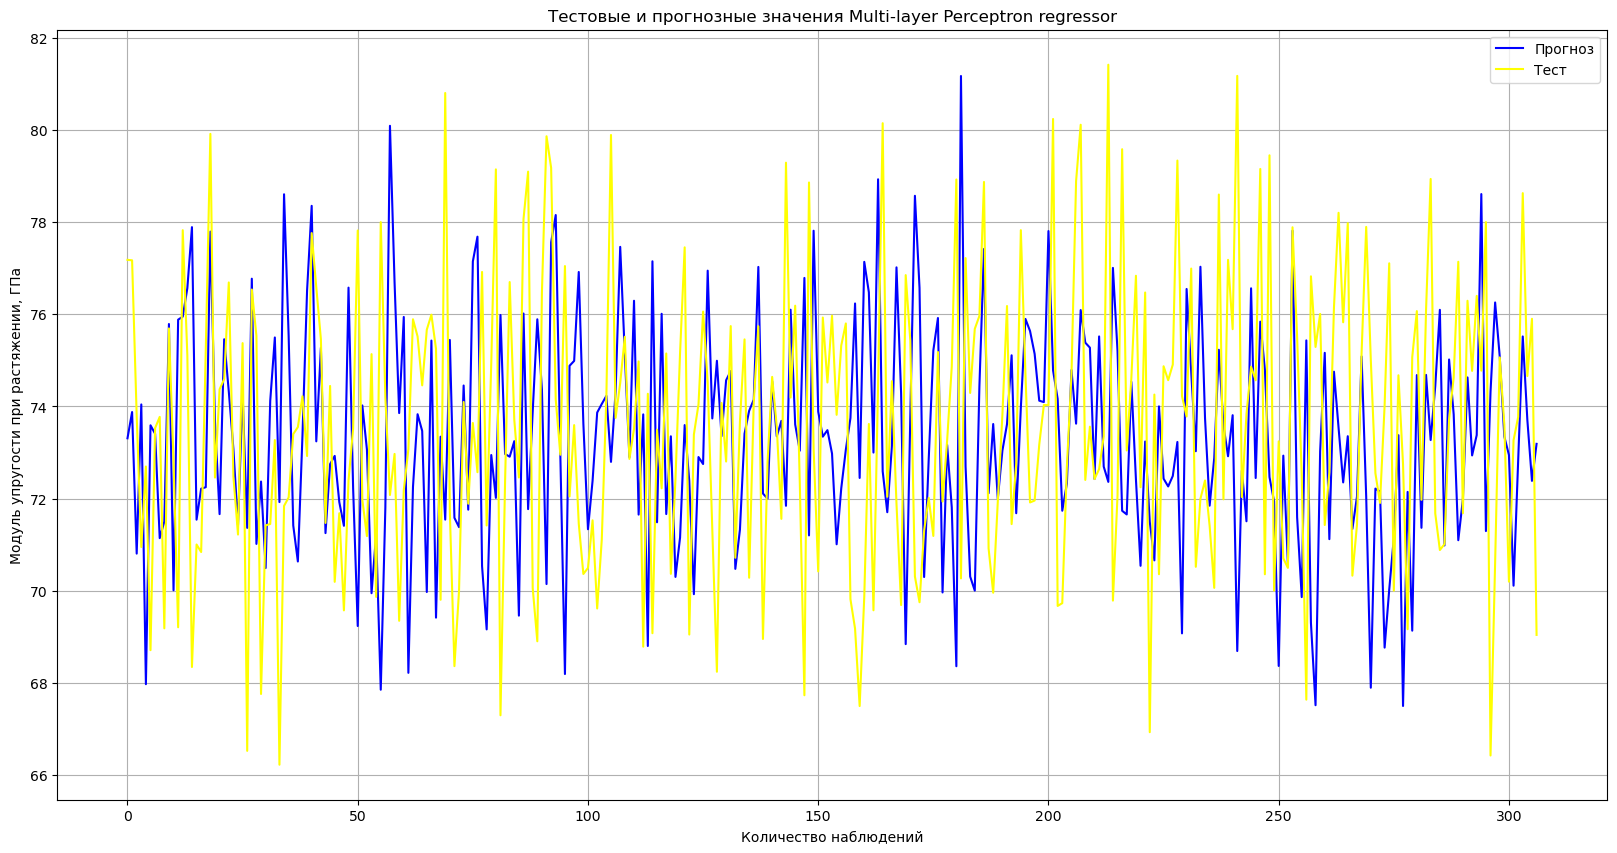

In [49]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Multi-layer Perceptron regressor")
plt.plot(y_pred_mlp, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [50]:
# сравним все модели по метрике МАЕ и R2
mae_r2_df = {'Регрессор': ['Linear Regression', 
                        'SVR rbf',
                        'SVR poly',
                        'K Neighbors Regressor',
                        'Decision Tree Regressor',
                        'Random Forest Regressor',
                        'Gradient Boosting Regressor',
                        'Stochastic Gradient Descent Regressor',
                        'Lasso Lars',
                        'Bayesian Ridge',
                        'Poisson Regressor',
                        'Multi-layer Perceptron regressor'], 
          'MAE': [mae_lin_reg, 
                  mae_svr_rbf,
                  mae_svr_poly,
                  mae_knr,
                  mae_dtr,
                  mae_rfr,
                  mae_gbr,
                  mae_sgdr,
                  mae_ll,
                  mae_br,
                  mae_pr,
                  mae_mlp],
          'R2 score': [r2_score_lin_reg, 
                       r2_score_svr_rbf,
                       r2_score_svr_poly,
                       r2_score_knr,
                       r2_score_dtr,
                       r2_score_rfr,
                       r2_score_gbr,
                       r2_score_sgdr,
                       r2_score_ll,
                       r2_score_br,
                       r2_score_pr,
                       r2_score_mlp]} 
mae_r2_df = pd.DataFrame.from_dict(mae_r2_df, orient='index')
mae_r2_df.T

,Регрессор,MAE,R2 score
0,Linear Regression,2.519962,-0.02778
1,SVR rbf,2.61258,-0.131368
2,SVR poly,2.933201,-0.490473
3,K Neighbors Regressor,2.491875,-0.008515
4,Decision Tree Regressor,2.522181,-0.027262
5,Random Forest Regressor,2.564905,-0.056906
6,Gradient Boosting Regressor,2.57924,-0.11011
7,Stochastic Gradient Descent Regressor,2.519193,-0.026995
8,Lasso Lars,2.509005,-0.021567
9,Bayesian Ridge,2.505908,-0.019647


In [51]:
# Пропустим через Pipeline

In [54]:
# Создаем пайплайн из моделей и препроцессоров
pipeline = Pipeline([('preprocessing', StandardScaler()), ('regressor', SVR())])
param_grid = [{'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [LinearRegression()]},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [SVR()],
                'regressor__kernel' : ['poly', 'rbf', 'sigmoid'],
                'regressor__gamma': ['scale', 'auto'],
                'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100, 300]},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [KNeighborsRegressor()],
                'regressor__n_neighbors' : [3, 5, 7, 9, 13, 15],
                'regressor__weights' : ['uniform', 'distance']},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [DecisionTreeRegressor()],
                'regressor__criterion' : ['squared_error', 'friedman_mse', 'mean_absolute_error', 'poisson'],
                'regressor__splitter' : ['best', 'random']},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [RandomForestRegressor(random_state=26)],
                'regressor__n_estimators' : [50, 100, 150, 200],
                'regressor__criterion' : ['squared_error', 'friedman_mse', 'mean_absolute_error', 'poisson']},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [GradientBoostingRegressor(random_state=26)], 
                'regressor__n_estimators' : [50, 100, 150, 200],
                'regressor__criterion' : ['squared_error', 'friedman_mse', 'mean_absolute_error', 'poisson']},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [SGDRegressor()],
                'regressor__max_iter' : [500, 1000, 1500],
                'regressor__loss' : ['squared_error', 'huber', 'absolute_error', 'quantile']},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [LassoLars()],
                'regressor__alpha' : [0, 0.1, 0.5, 1, 1.5],
                'regressor__max_iter' : [100, 300, 500, 1000]},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [BayesianRidge()],
                'regressor__n_iter': [100, 300, 500, 1000]},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [PoissonRegressor()],
                'regressor__alpha' : [0, 0.1, 0.5, 1, 1.5],
                'regressor__max_iter' : [100, 300, 500, 1000]},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [MLPRegressor(random_state=26)], 
                'regressor__activation' : ['identity', 'logistic', 'tanh', 'relu'],
                'regressor__max_iter' : [100, 500, 1000, 2000],
                'regressor__solver' : ['lbfgs', 'sgd', 'adam']}]
grid = GridSearchCV(pipeline, param_grid, cv=10)
grid.fit(x_train, np.ravel(y_train))
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Наилучшее значение правильности перекрестной проверки: {:.2f}".format(grid.best_score_))
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(x_test, y_test)))

Наилучшие параметры:
{'preprocessing': StandardScaler(), 'regressor': SVR(C=0.1), 'regressor__C': 0.1, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}

Наилучшее значение правильности перекрестной проверки: -0.02
Правильность на тестовом наборе: -0.03


In [55]:
# Применим библиотеку lazypredict
import lazypredict
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
BayesianRidge                               -0.07      -0.02  3.09        0.03
AdaBoostRegressor                           -0.07      -0.02  3.09        0.06
LarsCV                                      -0.07      -0.02  3.09        0.02
LassoLars                                   -0.07      -0.02  3.09        0.02
LassoCV                                     -0.07      -0.02  3.09        0.07
Lasso                                       -0.07      -0.02  3.09        0.02
LassoLarsCV                                 -0.07      -0.02  3.09        0.03
DummyRegressor                              -0.07      -0.02  3.09        0.01
ElasticNetCV                                -0.07      -0.02  3.09        0.06
ElasticNet                                  -0.07      -0.02  3.09        0.01
GammaRegressor                              -0.07   